In [1]:
%matplotlib inline 

from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def diff_forward(f, x: float, h: float = 1e-09) -> float:
    return (f(x + h) - f(x)) / h

def diff_central(f, x: float, h: float = 1e-09) -> float:
    return (f(x + h/2) - f(x - h/2)) / h

def diff_backward(f, x: float, h: float = 1e-09) -> float:
    return (f(x) - f(x - h)) / h

def diff_complex(f, x:float, h: float = 1e-09) -> float:
    return np.imag(f(x + h * 1.0j)) / h

$f(x)$ = $sin(x^{2})$

$x$ = $\frac{\pi}{2}$

$f^{'}(x)$ = $2  x  cos(x^{2})$

In [3]:
x = np.pi / 2
true_diff = 2 * x * np.cos(x ** 2)
true_diff

-2.4542495411512917

In [4]:
step_sizes = sorted([eval('1e-0{}'.format(x)) for x in range(19)])
step_sizes

[1e-18,
 1e-17,
 1e-16,
 1e-15,
 1e-14,
 1e-13,
 1e-12,
 1e-11,
 1e-10,
 1e-09,
 1e-08,
 1e-07,
 1e-06,
 1e-05,
 0.0001,
 0.001,
 0.01,
 0.1,
 1.0]

In [5]:
f = lambda x: np.sin(x ** 2)
diff_forward_at_x = [diff_forward(f, np.pi / 2, h) for h in step_sizes]
diff_central_at_x = [diff_central(f, np.pi / 2, h) for h in step_sizes]
diff_backward_at_x = [diff_backward(f, np.pi / 2, h) for h in step_sizes]
diff_complex_at_x = [diff_complex(f, np.pi / 2, h) for h in step_sizes]

In [6]:
step_sizes_power = sorted([np.log10(x) for x in step_sizes])

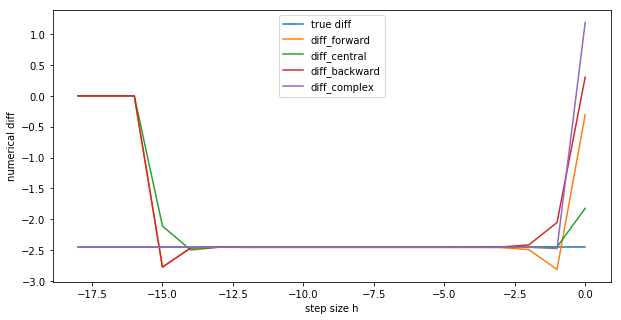

In [7]:
fix, ax = plt.subplots(figsize=(10, 5))

plt.plot(step_sizes_power, [true_diff] * len(step_sizes), label='true diff')
plt.plot(step_sizes_power, diff_forward_at_x, label='diff_forward')
plt.plot(step_sizes_power, diff_central_at_x, label='diff_central')
plt.plot(step_sizes_power, diff_backward_at_x, label='diff_backward')
plt.plot(step_sizes_power, diff_complex_at_x, label='diff_complex')

plt.legend()
plt.xlabel('step size h')
plt.ylabel('numerical diff')
plt.legend();

### Automatic Differentiation 

#### Forward Accumulation 

Dual numbers can be expressed mathematically by including the abstract quantity $\epsilon$, where $\epsilon^{2}$ is defined to be 0. Like a complex number, a dual number is writted $a + b\epsilon$ where a and b are both real values. We have:

$(a + \epsilon b) + (c + \epsilon d) = (a + c) + (b + d)\epsilon$ <br><br>
$(a + \epsilon b) * (c + \epsilon d) = ac + (ad + bc)\epsilon$

Dual number is a pair that we get after applying some operation. For example:
x -> log -> y <br>
Here we have: <br><br>
y = log(x) <br><br>
$\dot{y} = \frac{1}{x}\dot{x}$

where derivatives are with respect to some target variable (if it is x, then $\dot{x}$ = 1 and $\dot{y} = \frac{1}{x}$)

In [8]:
Dual = namedtuple('Dual', 'value, derivative')

In [9]:
def add(x1: Dual, x2: Dual) -> Dual:
    return Dual(x1.value + x2.value,
               x1.derivative + x2.derivative)

In [10]:
def mult(x1: Dual, x2: Dual) -> Dual:
    return Dual(x1.value * x2.value,
               x1.value * x2.derivative + x1.derivative * x2.value)

In [11]:
def ln(x: Dual) -> Dual:
    return Dual(np.log(x.value), x.derivative / x.value)

In [12]:
def max_(x: Dual, n: int) -> Dual:
    return Dual(max(x.value, n), x.derivative if x.value > n else 0)

In [13]:
a = Dual(3, 1)
b = Dual(2, 0)

In [14]:
ln(add(mult(a, b), max_(a, 2)))

Dual(value=2.1972245773362196, derivative=0.3333333333333333)

#### ex 2.1 
Adopt the forward difference method to approximate the Hessian of $f(x)$ using its gradient, $\nabla f(x)$.

$\frac{\partial f}{\partial x_{i} \partial x_{j}}$ = $\frac{\Delta f(x + he_{j})_{i} - \Delta f(x)_{i}}{h}$

#### ex 2.2 
What is a drawback of the central difference method over other finite difference methods if we already know $f(x)$. 

#### sol
We cannot reuse this value and have to compute f twice instead.

#### ex 2.3
Compute the gradient of $f(x) = ln(x) + e^{x} + \frac{1}{x}$ for a point x close to zero. What dominates in the expression? 

#### sol 
$\frac{df}{dx} = \frac{1}{x} + e^{x} - \frac{1}{x^{2}}$ <br><br>
This expression is dominated by $\frac{1}{x^{2}}$.

#### ex 2.4
Suppose f(x) is a real-valued function that is also defined for complex inputs. If $f(3 + ih) = 2 + 4ih$, what is $f^{'}(3)$?

#### sol 
$f^{'}(x) = \frac{im[f(x + ih)]}{h}$, so <br>
$f^{'}(3)$ = 4

#### ex 2.5
Draw the computational graph for $f(x, y) = sin(x + y^{2})$. Use the computational graph with forward graph with forward computation to compute $\frac{\partial f}{\partial y}$ at (x, y) = (1, 1). Label the intermediate values and partial derivatives as they are propagated through the graph. 

#### sol 

In [15]:
def sin(x: Dual) -> Dual:
    return Dual(np.cos(x.value), x.derivative * np.cos(x.value))

In [16]:
def square(x: Dual) -> Dual:
    return Dual(x.value ** 2, 2 * x.value * x.derivative)

Manually <br>
$\frac{\partial f}{\partial y} = 2ycos(x + y^{2})$ <br>
$\frac{\partial f}{\partial y}(1, 1) = 2cos(1 + 1) = 2cos(2)$

In [17]:
2 * np.cos(2)

-0.8322936730942848

In [18]:
x = Dual(1, 0)
y = Dual(1, 1)
sin(add(x, square(y)))

Dual(value=-0.4161468365471424, derivative=-0.8322936730942848)